Importing Libraries

In [29]:
import os
import tensorflow as tf

# For data maniplution
import pandas as pd
import numpy as np

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# for dataset handling and MAE
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.base import clone
from sklearn.pipeline import make_pipeline

# importing models for training and testing
import lightgbm as lgbm
from lightgbm import *
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


In [30]:
# load train dataset to dataframe
data_train = pd.read_csv('train.csv').drop(['row_id', 'time_id'], axis=1)

In [31]:
# load test dataset to dataframe
data_test = pd.read_csv('test.csv').drop(['row_id', 'time_id'], axis=1)

In [32]:
# displaying the first 10 rows
data_train.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333


###Exploratory Data Analysis

In [33]:
# getting information about the train data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int64(4)
memory usage: 599.4 MB


In [34]:
# getting descriptive statistics about the train data
data_train.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02


In [35]:
# Shape of the data: number of rows and columns
data_train.shape

(5237980, 15)

In [36]:
# checking for null values
data_train.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
dtype: int64

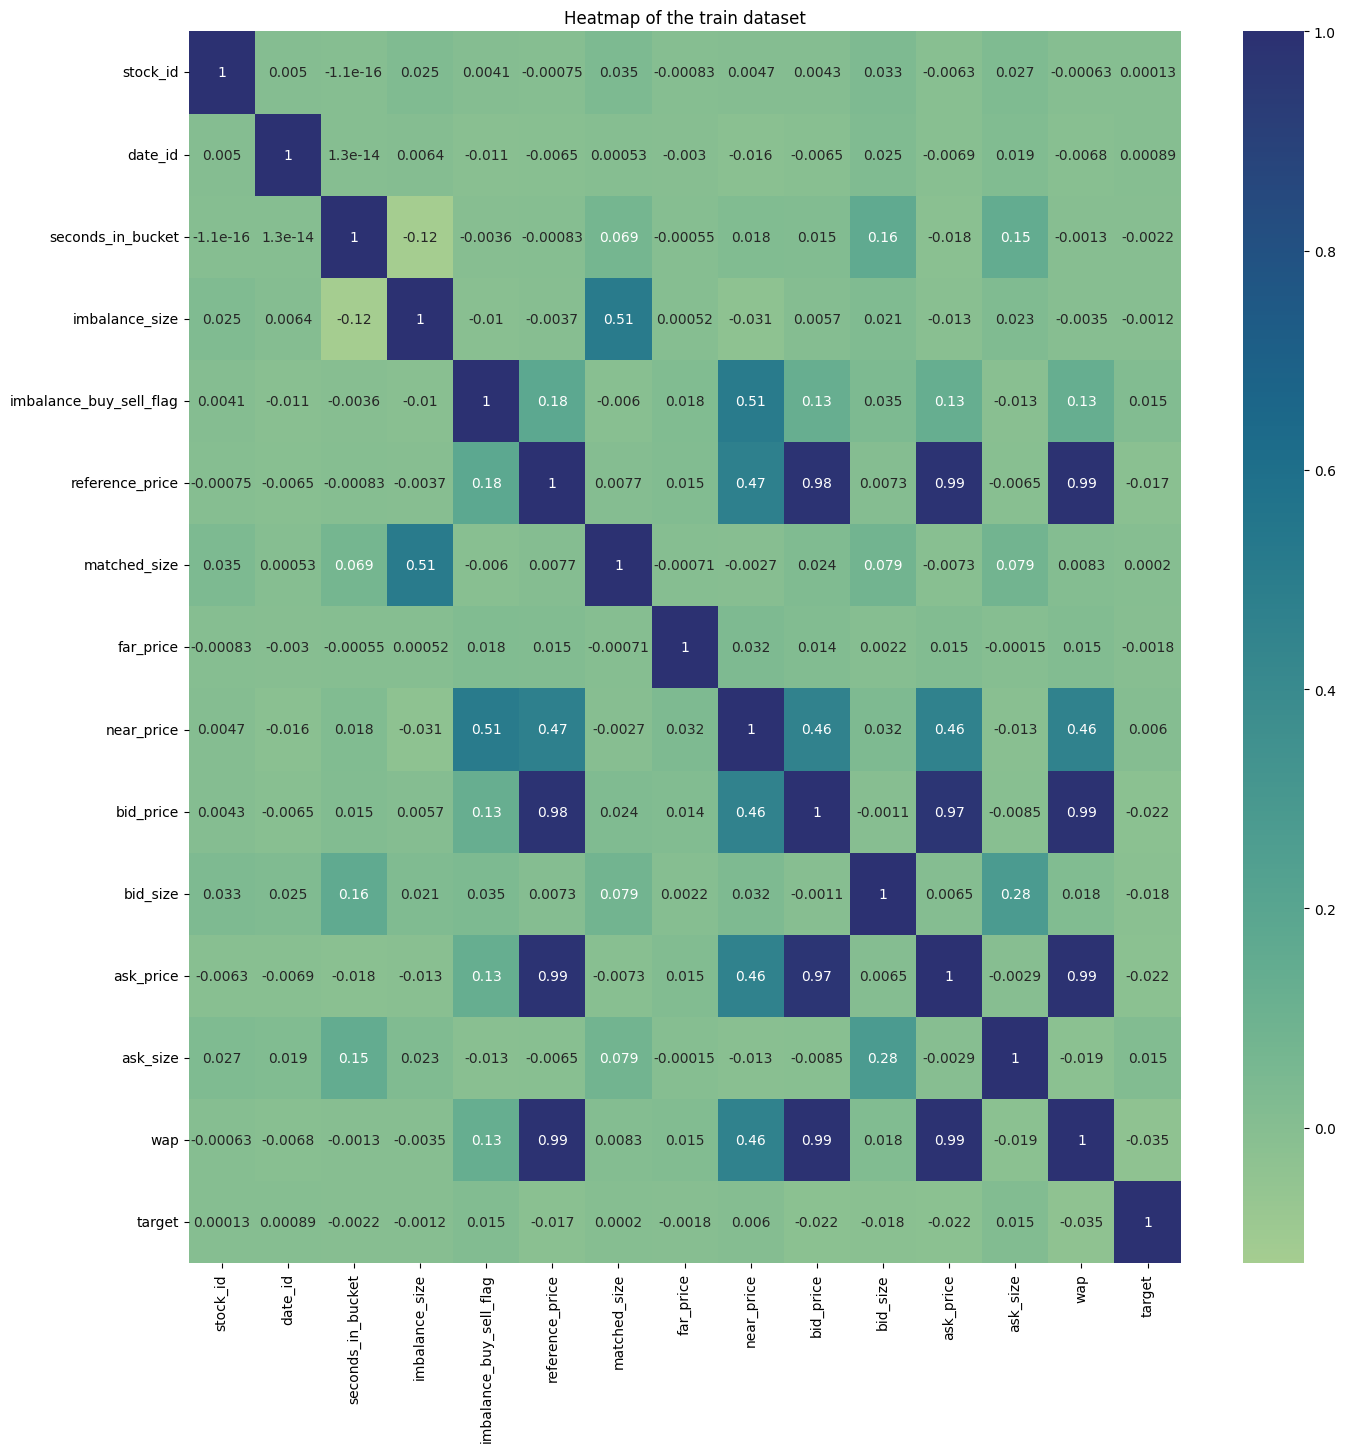

In [84]:
# plotting the heatmap for the train dataset
plt.figure(figsize=(16,16))
sns.heatmap(data_train.corr(),annot=True,cmap='crest')
plt.title('Heatmap of the train dataset')
plt.show()

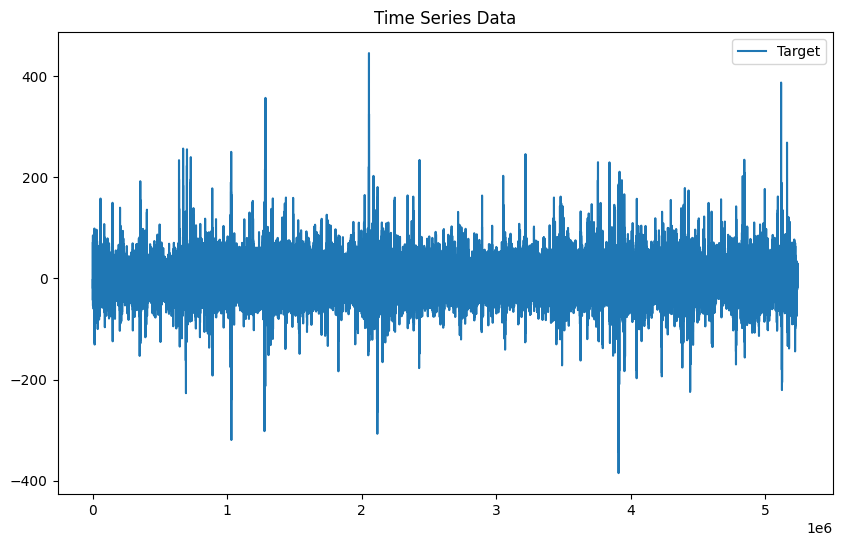

In [85]:
# visualize the time series data
plt.figure(figsize=(10, 6))
plt.plot(data_train['target'], label='Target')
plt.title('Time Series Data')
plt.legend()
plt.show()

In [22]:
# new dataframe with null values replaced by 0
train_df_0 = data_train.copy()
train_df_0.fillna(0, inplace=True)
train_df_0.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.0,0.0,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.0,0.0,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.0,0.0,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.0,0.0,0.999394,16485.54,1.000016,434.10,1.0,-7.349849
5,5,0,0,0.00,0,1.000635,13552875.92,0.0,0.0,0.999779,1962.72,1.000635,5647.65,1.0,6.779432
6,6,0,0,969969.40,1,1.000115,3647503.98,0.0,0.0,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819
7,7,0,0,9412959.10,1,0.999818,21261245.87,0.0,0.0,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801
8,8,0,0,2394875.85,1,0.999916,9473209.08,0.0,0.0,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001
9,9,0,0,3039700.65,-1,1.000969,6248958.45,0.0,0.0,0.999354,6191.00,1.000646,6199.00,1.0,7.970333


In [23]:
# new dataframe with null values replaced by mean
train_df_mean = data_train.copy()
train_df_mean.fillna(train_df_mean.mean(), inplace=True)
train_df_mean.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.001713,0.99966,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,1.001713,0.99966,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,1.001713,0.99966,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,1.001713,0.99966,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,1.001713,0.99966,0.999394,16485.54,1.000016,434.10,1.0,-7.349849
5,5,0,0,0.00,0,1.000635,13552875.92,1.001713,0.99966,0.999779,1962.72,1.000635,5647.65,1.0,6.779432
6,6,0,0,969969.40,1,1.000115,3647503.98,1.001713,0.99966,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819
7,7,0,0,9412959.10,1,0.999818,21261245.87,1.001713,0.99966,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801
8,8,0,0,2394875.85,1,0.999916,9473209.08,1.001713,0.99966,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001
9,9,0,0,3039700.65,-1,1.000969,6248958.45,1.001713,0.99966,0.999354,6191.00,1.000646,6199.00,1.0,7.970333


In [24]:
# new dataframe with null values replaced by first mode
train_df_mode = data_train.copy()

# selecting first mode if more than one
mode_values = train_df_mode.mode().iloc[0]
train_df_mode.fillna(mode_values, inplace=True)
train_df_mode.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.0,1.0,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,1.0,1.0,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,1.0,1.0,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,1.0,1.0,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,1.0,1.0,0.999394,16485.54,1.000016,434.10,1.0,-7.349849
5,5,0,0,0.00,0,1.000635,13552875.92,1.0,1.0,0.999779,1962.72,1.000635,5647.65,1.0,6.779432
6,6,0,0,969969.40,1,1.000115,3647503.98,1.0,1.0,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819
7,7,0,0,9412959.10,1,0.999818,21261245.87,1.0,1.0,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801
8,8,0,0,2394875.85,1,0.999916,9473209.08,1.0,1.0,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001
9,9,0,0,3039700.65,-1,1.000969,6248958.45,1.0,1.0,0.999354,6191.00,1.000646,6199.00,1.0,7.970333


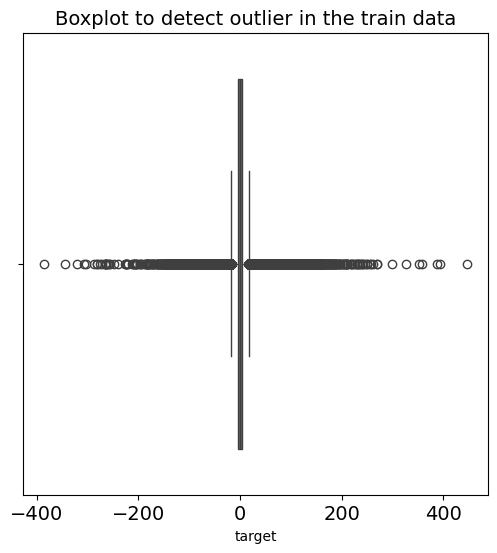

In [86]:
# checking outliers in the data
plt.figure(figsize=(6,6))
plt.title("Boxplot to detect outlier in the train data", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.boxplot(x=data_train['target'])
plt.show()

In [25]:
def find_outliers(dataframe, attribute):
    # determine the number of rows containing outliers
    # compute the 25th and 75th percentile value in target
    percentile25 = dataframe[attribute].quantile(0.25)
    percentile75 = dataframe[attribute].quantile(0.75)

    # compute the interquatile range in target
    iqr = percentile75 - percentile25

    # define upper limit and lower limit for non-outlier values
    upper_limit = percentile75 + (1.5 * iqr)
    lower_limit = percentile25 - (1.5 * iqr)
    print("Upper Limit:", upper_limit)
    print("Lower_Limit:", lower_limit)

    # identify the subset pf data containing outliers in target
    outliers = dataframe[(dataframe[attribute] > upper_limit) | (dataframe[attribute] < lower_limit)]

    # count how many rows in the data contain outliers in `target`
    print("Number of rows in the data containing outliers in ", attribute, ":", len(outliers))


In [27]:
print('For train_df_0: ')
find_outliers(train_df_0, "target")

print('\nFor train_df_mean: ')
find_outliers(train_df_mean, "target")

print('\nFor train_df_mode: ')
find_outliers(train_df_mode, "target")

For train_df_0: 
Upper Limit: 17.86351195
Lower_Limit: -18.013715649999998
Number of rows in the data containing outliers in  target : 292263

For train_df_mean: 
Upper Limit: 17.86351195
Lower_Limit: -18.013715649999998
Number of rows in the data containing outliers in  target : 292263

For train_df_mode: 
Upper Limit: 17.86351195
Lower_Limit: -18.013715649999998
Number of rows in the data containing outliers in  target : 292263


In [87]:
# handling outliers using log

train_df_0_log = train_df_0.copy()
train_df_0_log['target'] = np.log1p(pd.to_numeric(train_df_0_log['target'], errors='coerce'))

# train_df_mean_log = train_df_mean.copy()
# train_df_mean_log['target'] = np.log1p(pd.to_numeric(train_df_mean_log['target'], errors='coerce'))

# train_df_mode_log = train_df_mode.copy()
# train_df_mode_log['target'] = np.log1p(pd.to_numeric(train_df_mode_log['target'], errors='coerce'))

c:\Users\avani\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [88]:
# creating a RobustScaler obj
scaler = RobustScaler()

# handling outliers using robust scaling
train_df_0_rob = train_df_0.copy()
train_df_0_rob['target'] = scaler.fit_transform(train_df_0_rob['target'].values.reshape(-1, 1))

# train_df_mean_rob = train_df_mean.copy()
# train_df_mean_rob['target'] = scaler.fit_transform(train_df_mean_rob['target'].values.reshape(-1, 1))

# train_df_mode_rob = train_df_mode.copy()
# train_df_mode_rob['target'] = scaler.fit_transform(train_df_mode_rob['target'].values.reshape(-1, 1))


In [11]:
# setting a seed value to ensure reproducibility across different runs
seed = 69

# creating a TimeSeriesSplit object with 10 splits. 
# TimeSeriesSplit is a cross-validator that provides train/test indices to split time series data.
tss = TimeSeriesSplit(10)

# setting the Python hash seed to the same value as the random seed
# ensuring reproducibility when using hash-based operations in Python.
os.environ['PYTHONHASHSEED'] = '69'

# setting the random seed for TensorFlow's Keras API to ensure reproducibility in neural network training. 
tf.keras.utils.set_random_seed(seed)

In [89]:
# extracting rows where the target values are not NaN (not missing)
train_df_0_X = train_df_0[~train_df_0.target.isna()]

# extracting the target values corresponding to the non-missing rows
train_df_0_Y = train_df_0_X.pop('target')

In [45]:
# lightgbm model
model = LGBMRegressor(random_state = seed, objective = 'mae',  n_estimators=500)

# training the Model
model.fit(train_df_0_X, train_df_0_Y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 5237980, number of used features: 14
[LightGBM] [Info] Start training from score -0.060201


LGBMRegressor(n_estimators=500, objective='mae', random_state=69)

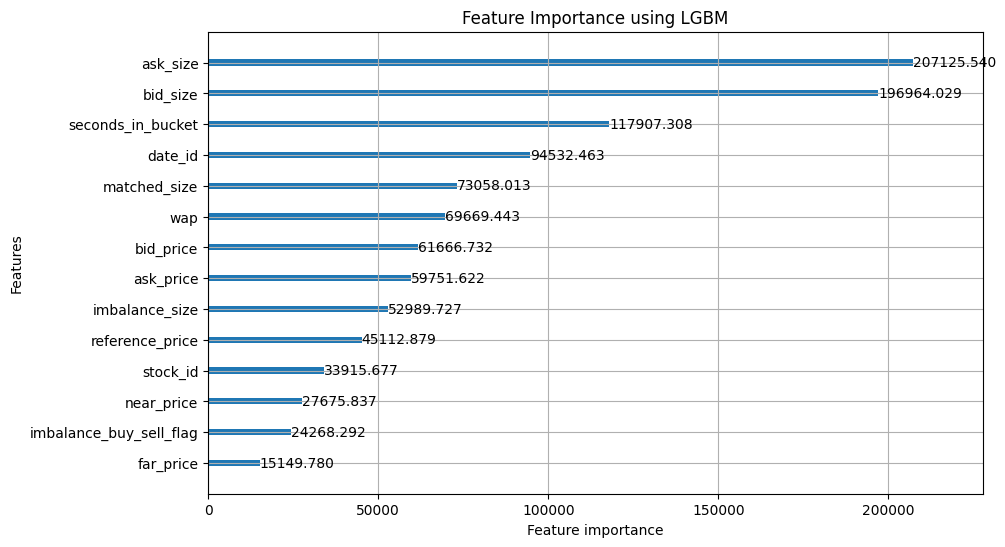

In [49]:
# plot feature importance
lgbm.plot_importance(model, importance_type='gain', figsize=(10,6), title='Feature Importance using LGBM')
plt.show()

In [37]:
def feature_addition(x):
    """
    Function to add various features to the input DataFrame.

    Parameters:
    - x: Input DataFrame

    Returns:
    - DataFrame with additional features
    """
    # list of initial features
    list_of_features = ['seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                        'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    # create a copy of the input DataFrame
    x_copy = x.copy()
    
    # finding imbalance ratios
    # measures the relative difference between the number of shares available for buying (bid) and selling (ask). 
    # it helps the model understand the balance between buyers and sellers in the order book.
    x_copy['imb_s1'] = x.eval('(bid_size - ask_size) / (bid_size + ask_size)')

    # captures the relative difference between the total unmatched shares and the shares that have found a match. 
    # this provides insights into the imbalance between supply and demand.
    x_copy['imb_s2'] = x.eval('(imbalance_size - matched_size) / (matched_size + imbalance_size)')
    
    # list of price-related features
    list_of_prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    # for each pair of prices the code calculates a ratio that expresses the imbalance between them. 
    # valuable for understanding how different price levels interact and influence each other.
    for i, a in enumerate(list_of_prices):
        for j, b in enumerate(list_of_prices):
            if i > j:
                # price differences as ratios
                x_copy[f'{a}_{b}_imb'] = x.eval(f'({a} - {b}) / ({a} + {b})')
                list_of_features.append(f'{a}_{b}_imb')

    # takes into account sets of three prices and calculates a ratio based on their maximum, minimum, and middle values. 
    # introduces a more sophisticated understanding of the relationships between multiple price levels.
    # in financial markets, understanding the dynamics between various price levels is crucial for predicting price movements and making informed trading decisions.               
    for i, a in enumerate(list_of_prices):
        for j, b in enumerate(list_of_prices):
            for k, c in enumerate(list_of_prices):
                if i > j and j > k:
                    # triple-wise price differences as ratios
                    max_value = x[[a, b, c]].max(axis=1)
                    min_value = x[[a, b, c]].min(axis=1)
                    mid_value = x[[a, b, c]].sum(axis=1) - min_value - max_value
 
                    x_copy[f'{a}_{b}_{c}_imb2'] = (max_value - mid_value) / (mid_value - min_value)
                    list_of_features.append(f'{a}_{b}_{c}_imb2')
                    
    # additional Features
    # measures the gap between the highest price a buyer is willing to pay (ask) and the lowest price a seller is willing to accept (bid)
    x_copy['spread'] = x['ask_price'] - x['bid_price']

    # provides a central reference point between the highest and lowest prices in a given time window
    x_copy['midpoint'] = 0.5 * (x['ask_price'] + x['bid_price'])

    # measures the overall range of prices during a specific time window
    x_copy['price_range'] = x['far_price'] - x['near_price']

    # indicates how much the WAP deviates from the reference price
    x_copy['wap_difference'] = x['wap'] - x['reference_price']
    
    # volatility Features
    # represents the volatility in the price of the stock over a 10-period window
    # higher values indicate greater price volatility.
    x_copy['price_volatility'] = x['wap'].pct_change().rolling(window=10).std()

    # represents the volatility in the imbalance size over a 10-period window
    # higher values suggest more significant fluctuations in the imbalance size.
    x_copy['imbalance_volatility'] = x_copy['imbalance_size'].pct_change().rolling(window=10).std()

    # represents the average ask size over the past 10 periods
    x_copy['ask_size_mean'] = x['ask_size'].rolling(window=10).mean()

    # represents the average bid size over the past 10 periods
    x_copy['bid_size_mean'] = x['bid_size'].rolling(window=10).mean()

    # appending the newly created features into the list
    list_of_features.extend(['imb_s1', 'imb_s2', 'spread', 'midpoint', 'price_range', 'wap_difference', 'price_volatility', 'imbalance_volatility', 'ask_size_mean', 'bid_size_mean'])
 
    return x_copy[list_of_features]
 
FeatureAddition = FunctionTransformer(feature_addition)

In [38]:
def train_and_predict(estimator, cv = tss, label = ''):

    """
    Trains a model using cross-validation, makes predictions, and evaluates performance.

    Parameters:
    - model: The machine learning model to be trained and evaluated.
    - cross_validator: The cross-validator for splitting the data during cross-validation.
    - label: A label to identify the model or experiment.

    Returns:
    - val_scores: List of validation scores for each fold.
    - val_predictions: Combined validation predictions.
    """
    

    # extract features and labels from the training dataset
    X = train_df_0[~train_df_0.target.isna()]
    # X = train_df_mean[~train_df_mean.target.isna()]
    # X = train_df_mode[~train_df_mode.target.isna()]
    
    # X = train_df_0_log[~train_df_0_log.target.isna()]
    # X = train_df_mean_log[~train_df_mean_log.target.isna()]
    # X = train_df_mode_log[~train_df_mean_log.target.isna()]

    # X = train_df_0_rob[~train_df_0_rob.target.isna()]
    # X = train_df_mean_rob[~train_df_mean_rob.target.isna()]
    # X = train_df_mode_rob[~train_df_mode_rob.target.isna()]

    y = X.pop('target')
    
    # initializing prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores = [], []
    
    # train the model, predict, and evaluate metrics for each fold
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        # clone the model to ensure a fresh instance for each fold
        model = clone(estimator)
        
        # train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        # validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        # model training
        model.fit(X_train, y_train)
        
        # predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        # accumulate validation predictions         
        val_predictions[val_idx] += val_preds
        
        # evaluate model for a fold
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)
        
        # append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)

    print('Train Dataframe with NA replaced with 0')
    # print('Train Dataframe with NA replaced with mean')
    # print('Train Dataframe with NA replaced with mode')

    # print('Train Dataframe with NA replaced with 0 and outliers handled with log')
    # print('Train Dataframe with NA replaced with mean and outliers handled with log')
    # print('Train Dataframe with NA replaced with mode and outliers handled with log')

    # print('Train Dataframe with NA replaced with 0 and outliers handled with Robust Scaling')
    # print('Train Dataframe with NA replaced with mean and outliers handled with Robust Scaling')
    # print('Train Dataframe with NA replaced with mode and outliers handled with Robust Scaling')
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions

In [83]:
# list of models to be trained and evaluated
models = [
    # LightGBM Model s another gradient boosting framework designed for speed and efficiency. It's optimized for distributed and efficient training on large datasets and is suitable for tabular data.
    ('LightGBM', LGBMRegressor(random_state=seed, objective='mae', n_estimators=500)),
    # CatBoost Model is a gradient boosting library that handles categorical features well without extensive preprocessing. It's robust and performs well on a variety of datasets. The verbose=0 parameter suppresses auxiliary information during training.
    # ('CatBoost', CatBoostRegressor(random_state=seed, objective='MAE', verbose=0))
]
 
# looping through each model in the list
for (label, model) in models:
    # train and evaluate the model using the train_and_predict function
    ans = train_and_predict(
        # create a pipeline with feature addition and the current model
        make_pipeline(
            FeatureAddition,  # custom feature addition transformer
            model  # current regression model
        ),
        label=label  # label for identifying the model in the results
    )



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14083
[LightGBM] [Info] Number of data points in the train set: 476180, number of used features: 57
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14083
[LightGBM] [Info] Number of data points in the train set: 952360, number of used features: 57
[LightGBM] [Info] Start training from score -0.050068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.369803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [90]:
# we use a pipeline to streamline the machine learning workflow, including feature addition and the LightGBM Regressor.
model = make_pipeline(
    FeatureAddition, # custom feature addition transformer
    LGBMRegressor(random_state = seed, objective = 'mae',  n_estimators=500)
)

# training the Model
model.fit(train_df_0_X, train_df_0_Y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.453218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14083
[LightGBM] [Info] Number of data points in the train set: 5237980, number of used features: 57
[LightGBM] [Info] Start training from score -0.060201


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function feature_addition at 0x0000022B6D006DC0>)),
                ('lgbmregressor',
                 LGBMRegressor(n_estimators=500, objective='mae',
                               random_state=69))])

In [91]:
# making predictions on the Test Data
# loading the sample submission file to get the required structure
sample_prediction = pd.read_csv('sample_submission.csv')

# predicting the target values for the test data using the trained model
sample_prediction['target'] = model.predict(data_test)    

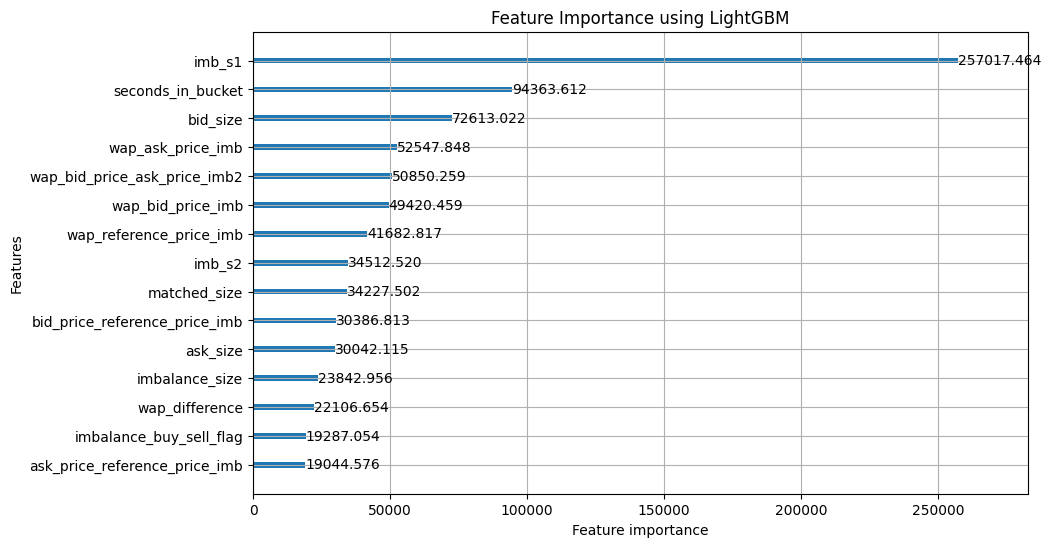

In [92]:
# extract the LightGBM model from the pipeline
lgb_model = model.named_steps['lgbmregressor']

# plot feature importance
lgbm.plot_importance(lgb_model, importance_type='gain', max_num_features = 15, figsize=(10, 6), title='Feature Importance using LightGBM')
plt.show()

In [93]:
# printing first few rows
sample_prediction.head()

,time_id,row_id,target
0,26290,478_0_0,-0.861389
1,26290,478_0_1,1.128732
2,26290,478_0_2,1.597335
3,26290,478_0_3,-1.097265
4,26290,478_0_4,-1.645314


In [94]:
# finding total NaN values
sample_prediction.isna().sum()

time_id    0
row_id     0
target     0
dtype: int64

Splitting the Training Data as Training and Testing dataset

In [95]:
# feature and label for Train Dataframe with NA replaced with 0
X = train_df_0.drop('target', axis=1)
y = train_df_0['target']

# # feature and label for Train Dataframe with NA replaced with mean
# X = train_df_mean.drop('target', axis=1)
# y = train_df_mean['target']

# # feature and label for Train Dataframe with NA replaced with mode
# X = train_df_mode.drop('target', axis=1)
# y = train_df_mode['target']

# # feature and label for Train Dataframe with NA replaced with 0 and outliers handled with log
# X = train_df_0_log.drop('target', axis=1)
# y = train_df_0_log['target']

# # feature and label for Train Dataframe with NA replaced with mean and outliers handled with log
# X = train_df_mean_log.drop('target', axis=1)
# y = train_df_mean_log['target']

# # feature and label for Train Dataframe with NA replaced with mode and outliers handled with log
# X = train_df_mode_rob.drop('target', axis=1)
# y = train_df_mode_rob['target']

# feature and label for Train Dataframe with NA replaced with 0 and outliers handled with Robust Scaling
X2 = train_df_0_rob.drop('target', axis=1)
y2 = train_df_0_rob['target']

# # feature and label for Train Dataframe with NA replaced with mean and outliers handled with Robust Scaling
# X = train_df_mean_rob.drop('target', axis=1)
# y = train_df_mean_rob['target']

# # feature and label for Train Dataframe with NA replaced with mode and outliers handled with Robust Scaling
# X = train_df_mode_rob.drop('target', axis=1)
# y = train_df_mode_rob['target']

In [96]:
# split the data into training (80%), testing (10%), and validation (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [97]:
# split the data into training (80%), testing (10%), and validation (10%) sets
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=42)

In [98]:
# we use a pipeline to streamline the machine learning workflow, including feature addition and the LightGBM Regressor
model = make_pipeline(
    FeatureAddition, # custom feature addition transformer
    LGBMRegressor(random_state = seed, objective = 'mae', n_estimators=500) 
)

In [100]:
# training the model for train_df_0
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.832832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14083
[LightGBM] [Info] Number of data points in the train set: 4190384, number of used features: 57
[LightGBM] [Info] Start training from score -0.060201


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function feature_addition at 0x0000022B6D006DC0>)),
                ('lgbmregressor',
                 LGBMRegressor(n_estimators=500, objective='mae',
                               random_state=69))])

In [101]:
# predicting the values for X_test
y_test_pred = model.predict(X_test)

In [102]:
# predicting the values for X_val
y_test_val = model.predict(X_val)

In [104]:
# training the model for train_df_0_rob
model.fit(X_train2, y_train2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.004729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14083
[LightGBM] [Info] Number of data points in the train set: 4190384, number of used features: 57


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function feature_addition at 0x0000022B6D006DC0>)),
                ('lgbmregressor',
                 LGBMRegressor(n_estimators=500, objective='mae',
                               random_state=69))])

In [105]:
# predicting the values for X_test2
y_test_pred2 = model.predict(X_test2)

In [106]:
# predicting the values for X_val2
y_test_val2 = model.predict(X_val2)

In [103]:
# evaluate the model using Mean Absolute Error (MAE) on the validation set for train_df_0
mae_val = mean_absolute_error(y_val, y_test_val)
print(f'MAE on Validation Set: {mae_val:.4f}')

MAE on Validation Set: 6.2482


In [107]:
# evaluate the model using Mean Absolute Error (MAE) on the validation set for train_df_0_rob
mae_val2 = mean_absolute_error(y_val2, y_test_val2)
print(f'MAE on Validation Set: {mae_val2:.4f}')

MAE on Validation Set: 0.6966
